**Подключение библиотек и скриптов**

In [0]:
import pandas as pd
import numpy as np
import xgboost as xgb
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from scipy import interp
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.feature_selection import chi2, mutual_info_classif, RFECV
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, auc, \
                            log_loss, roc_auc_score, average_precision_score, confusion_matrix

**Подключение к Google Drive**

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Загрузка данных для обучения**

In [0]:
train_new = pd.read_csv('/content/drive/My Drive/train_new.csv', index_col=0)
train_new.head()

,user_id,is_churned,level,donate_total,trans_amt_1,trans_amt_2,trans_amt_3,trans_amt_4,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,reports_amt_1,reports_amt_2,reports_amt_3,reports_amt_4,sess_with_abusers_amt_1,sess_with_abusers_amt_2,sess_with_abusers_amt_3,sess_with_abusers_amt_4,session_amt_1,session_amt_2,session_amt_3,session_amt_4,disconnect_amt_1,disconnect_amt_2,disconnect_amt_3,disconnect_amt_4,avg_min_ping_1,avg_min_ping_2,avg_min_ping_3,avg_min_ping_4,session_player_1,session_player_2,session_player_3,session_player_4,win_rate_1,win_rate_2,win_rate_3,win_rate_4,leavings_rate_1,leavings_rate_2,leavings_rate_3,leavings_rate_4,kd_1,kd_2,kd_3,kd_4,gold_spent_1,gold_spent_2,gold_spent_3,gold_spent_4,silver_spent_1,silver_spent_2,silver_spent_3,silver_spent_4,age,gender,days_between_reg_fl,days_between_fl_df,has_return_date,has_phone_number
0,1e7edd8347e3aaeedf8c494b11240851e3fa0ad231b8f8...,0,43,88730.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.000000,6.5,1.000000,6.000000,1.0,2.000000,1.000000,0.500000,0.000000,0.000000,0.0,0.500000,54.000000,31.000000,42.000000,28.000000,1321.000000,8592.000000,1352.333333,7941.500000,3.000000,0.659091,1.000000,0.650000,0.000000,0.216667,0.000000,0.166667,2.000000,2.387302,1.034877,0.952632,0.000000,0.0,78.666667,0.000000,0.000000,40900.0,300.000000,25000.000000,26.0,0.0,0,7,1,1
1,f43cac5f14e06ca039b173e14c323ac0c1fd8492f0cf08...,0,50,44149.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,1.0,0.0,1.0,3.600000,4.8,4.666667,4.000000,1.4,1.500000,2.200000,1.428571,0.000000,0.250000,0.0,0.142857,65.666666,46.000000,48.333334,70.571429,4685.000000,5632.600000,5526.833333,5444.000000,1.123333,1.678571,2.125631,1.661905,0.018182,0.013333,0.000000,0.035714,1.375780,1.247101,1.262016,1.432277,0.000000,0.0,0.000000,0.000000,0.000000,41480.0,6266.666667,1400.000000,27.0,0.0,0,37,1,1
2,cc7450e0b182947998534ef137b05e07109c100aced0b6...,0,37,44931.00000,1.0,1.0,0.0,2.0,63.000000,350.0,0.0,130.0,1.0,1.0,1.0,2.0,4.166667,8.2,8.000000,8.571429,1.0,1.857143,1.714286,1.857143,0.857143,0.857143,1.0,1.142857,60.972222,49.161904,63.061508,63.773809,4710.166667,6543.400000,6317.000000,7550.571429,0.684722,0.653571,0.291667,0.518254,0.066667,0.096667,0.064935,0.077063,1.075181,1.364430,0.872192,0.938326,104.285714,0.0,1.428571,2.857143,14471.428571,31400.0,5714.285714,414.285714,21.0,0.0,0,153,1,1
3,5c583d57a1e9e53341fc239d41fb6983e667a04b1b4d94...,0,20,37538.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,28.433333,28.972222,29.000000,29.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,22.0,0.0,0,156,1,1
4,9bbaa1a2501e8dc83cf6c0c54ef139c75c99de09dcf4dc...,0,10,4100.97998,1.0,0.0,0.0,0.0,66.580002,0.0,0.0,0.0,0.0,0.0,2.0,0.0,4.250000,2.0,4.000000,1.400000,0.6,1.500000,1.500000,1.500000,0.800000,0.250000,0.5,0.250000,24.900000,24.500000,24.833333,24.733333,4124.400000,2755.833333,3776.800000,1949.000000,1.113333,0.733333,1.316667,1.000000,0.050000,0.305556,0.054286,0.111111,9.825229,10.025196,3.536477,10.131818,0.000000,0.0,0.000000,0.000000,0.000000,0.0,1666.666667,9838.000000,24.0,0.0,0,21,1,1


In [0]:
train_new.describe()

,is_churned,level,donate_total,trans_amt_1,trans_amt_2,trans_amt_3,trans_amt_4,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,reports_amt_1,reports_amt_2,reports_amt_3,reports_amt_4,sess_with_abusers_amt_1,sess_with_abusers_amt_2,sess_with_abusers_amt_3,sess_with_abusers_amt_4,session_amt_1,session_amt_2,session_amt_3,session_amt_4,disconnect_amt_1,disconnect_amt_2,disconnect_amt_3,disconnect_amt_4,avg_min_ping_1,avg_min_ping_2,avg_min_ping_3,avg_min_ping_4,session_player_1,session_player_2,session_player_3,session_player_4,win_rate_1,win_rate_2,win_rate_3,win_rate_4,leavings_rate_1,leavings_rate_2,leavings_rate_3,leavings_rate_4,kd_1,kd_2,kd_3,kd_4,gold_spent_1,gold_spent_2,gold_spent_3,gold_spent_4,silver_spent_1,silver_spent_2,silver_spent_3,silver_spent_4,age,gender,days_between_reg_fl,days_between_fl_df,has_return_date,has_phone_number
count,469475.000000,469475.000000,4.694750e+05,469475.000000,469475.000000,469475.000000,469475.000000,469475.000000,469475.000000,469475.000000,469475.000000,469475.000000,469475.000000,469475.000000,469475.000000,469475.000000,469475.000000,469475.000000,469475.000000,469475.000000,469475.000000,469475.000000,469475.000000,469475.000000,469475.000000,469475.000000,469475.000000,469475.000000,469475.000000,469475.000000,469475.000000,469475.000000,469475.000000,469475.000000,469475.000000,469475.000000,469475.000000,469475.000000,469475.000000,469475.000000,469475.000000,469475.000000,469475.000000,469475.000000,469475.000000,469475.000000,469475.000000,469475.000000,469475.000000,469475.000000,469475.000000,4.694750e+05,4.694750e+05,4.694750e+05,4.694750e+05,469475.000000,469475.0,469475.000000,469475.000000,469475.000000,469475.000000
mean,0.029448,26.792698,4.800206e+04,0.198513,0.182546,0.173069,0.173995,140.415895,134.262708,129.077459,133.300280,0.708455,0.707977,0.709422,0.703380,2.810628,2.938302,3.075788,3.175711,0.997169,0.997714,1.007816,1.028452,0.375617,0.385396,0.397086,0.414983,33.190376,33.453583,33.563482,33.682889,3265.955581,3379.027138,3512.251970,3622.309714,0.747296,0.723235,0.715966,0.710840,0.072856,0.071267,0.072153,0.073360,3.565562,3.389694,3.300992,3.210472,73.334719,72.931138,70.150866,69.289718,6.444131e+03,5.700765e+03,4.550476e+03,4.724096e+03,26.002226,0.0,14.340597,218.709164,0.882946,0.830589
std,0.169058,12.680296,8.576742e+04,0.573882,0.567848,0.562879,0.553329,597.573949,603.785240,613.631584,632.451995,1.586962,1.574771,1.567295,1.556799,3.677683,3.834196,3.993347,4.109293,1.134619,1.156297,1.168026,1.188481,1.888480,2.157656,1.811968,2.201080,23.906486,23.553533,23.591891,23.729100,4015.691844,4158.659831,4286.840526,4384.824816,3.125124,2.527616,2.412572,1.638846,1.239741,1.137892,0.638524,0.271250,60.417143,34.960178,26.118473,17.093699,380.674537,385.894325,407.242002,385.043766,2.559970e+04,1.978590e+04,1.452183e+04,1.475799e+04,8.341266,0.0,114.818230,363.410345,0.321485,0.375115
min,0.000000,10.000000,6.000000e-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.000000,0.0,-1.000000,-1.000000,0.000000,0.000000
25%,0.000000,17.000000,6.312000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.642857,24.361508,24.571429,24.625000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+0

**Обработка и баансировка данных для обучения**

In [0]:
X = train_new.drop(['user_id', 'is_churned'], axis=1)
y = train_new['is_churned']

X_mm = MinMaxScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_mm, y, 
                                                    test_size=0.3,
                                                    shuffle=True, 
                                                    stratify=y, 
                                                    random_state=100)

X_train_balanced, y_train_balanced = SMOTE(random_state=42, n_jobs=-1).fit_sample(X_train, y_train)

**Функции из ноутбука вебинара**

In [0]:
def evaluation(y_true, y_pred, y_prob):
    precision = precision_score(y_true=y_true, y_pred=y_pred)
    recall = recall_score(y_true=y_true, y_pred=y_pred)
    f1 = f1_score(y_true=y_true, y_pred=y_pred)
    ll = log_loss(y_true=y_true, y_pred=y_prob)
    roc_auc = roc_auc_score(y_true=y_true, y_score=y_prob)
    print('Precision: {}'.format(precision))
    print('Recall: {}'.format(recall))
    print('F1: {}'.format(f1))
    print('Log Loss: {}'.format(ll)) 
    print('ROC AUC: {}'.format(roc_auc)) 
    return precision, recall, f1, ll, roc_auc

def xgb_fit_predict(X_train, y_train, X_test, y_test):
    clf = xgb.XGBClassifier(max_depth=3,
                            n_estimators=100,
                            learning_rate=0.1,
                            nthread=5,
                            subsample=1.,
                            colsample_bytree=0.5,
                            min_child_weight = 3,
                            reg_alpha=0.,
                            reg_lambda=0.,
                            seed=42,
                            missing=1e10)

    clf.fit(X_train, y_train, eval_metric='aucpr', verbose=10)
    predict_proba_test = clf.predict_proba(X_test)
    predict_test = clf.predict(X_test)
    precision_test, recall_test, f1_test, log_loss_test, roc_auc_test = \
        evaluation(y_test, predict_test, predict_proba_test[:, 1])
    return clf


def plot_importance(importance, features, name):
    fi = pd.DataFrame(list(zip(features, importance))).sort_values(by=1, ascending=False)
    plt.figure(figsize=(16,6))
    plt.bar(range(fi.shape[0]), fi[1], align='center')
    plt.xticks(range(fi.shape[0]), fi[0], rotation=90)
    plt.title(name)
    plt.show()
    return fi

## Задание 1

***Используя признаки, отобранные взаимной информацией, RFE и PI, посмотрите качество XGBoost'а по аналогии с тем, как это делалось на уроке. При каком подходе к отбору признаков получается лучшее значение F1?***

Обучим базовый классификатор (xgboost):

In [0]:
%%time
base_clf = xgb_fit_predict(X_train_balanced, y_train_balanced, X_test, y_test)

Precision: 0.19800613496932515
Recall: 0.6224686595949855
F1: 0.3004421689550849
Log Loss: 0.21151145036845154
ROC AUC: 0.8938949132297043
CPU times: user 2min 41s, sys: 509 ms, total: 2min 41s
Wall time: 1min 23s


Метрика $F1 = 0.3$ достаточно мала, но присутствует разброс между точностью (0.198) и полнотой (0.622) - что дает шанс на traid-off.

**Взаимная информация**

In [0]:
%%time
mi = mutual_info_classif(X_train_balanced, y_train_balanced)

CPU times: user 11min 41s, sys: 4.38 s, total: 11min 45s
Wall time: 11min 46s


In [0]:
mi_features = pd.Series(mi, index=X.columns).sort_values(ascending=False).head(30).index

In [0]:
X_train_mi = pd.DataFrame(X_train_balanced, columns=X.columns)[mi_features]
X_test_mi = pd.DataFrame(X_test, columns=X.columns)[mi_features]

mi_clf = xgb_fit_predict(X_train_mi, y_train_balanced, X_test_mi, y_test)

Precision: 0.20333388347912196
Recall: 0.5940212150433944
F1: 0.30296323619820487
Log Loss: 0.2114422917643186
ROC AUC: 0.8872699616370663


Отбор лучших 30 признаков в данном случае не дал значимого прироста $F1$ и немного уменьшил разброс точности и полноты по сравнению с показателями качества базового классификатора.

**RFE (Recursive Feature Elimination)**

In [0]:
%%time
STEP = 5

selector = RFECV(estimator=base_clf, step=STEP, cv=StratifiedKFold(2), scoring='f1')
selector.fit(X_train_balanced, y_train_balanced)

rfecv_features = X.columns[selector.support_]

CPU times: user 32min 8s, sys: 6.63 s, total: 32min 15s
Wall time: 16min 57s


In [0]:
selector.n_features_

45

т.е. отобраны 45 признаков.

In [0]:
X_train_rfecv = pd.DataFrame(X_train_balanced, columns=X.columns)[rfecv_features]
X_test_rfecv = pd.DataFrame(X_test, columns=X.columns)[rfecv_features]

rfecv_clf = xgb_fit_predict(X_train_rfecv, y_train_balanced, X_test_rfecv, y_test)

Precision: 0.20056202328382175
Recall: 0.6022179363548699
F1: 0.3009094741914112
Log Loss: 0.2076757688243681
ROC AUC: 0.8903300220740039


Рекурсивный отбор признаков также ощутимо не улучшил показатели качества базового классификатора.

**Permutation Importance (PI)**

In [0]:
#!pip install eli5
from eli5.sklearn import PermutationImportance

In [0]:
%%time
perm = PermutationImportance(base_clf, random_state=42).fit(X_train_balanced, y_train_balanced)

res = pd.DataFrame(X.columns, columns=['feature'])
res['score'] = perm.feature_importances_
res['std'] = perm.feature_importances_std_
res = res.sort_values(by='score', ascending=False).reset_index(drop=True)

CPU times: user 14min 20s, sys: 2.3 s, total: 14min 22s
Wall time: 8min 11s


In [0]:
perm_features = res.loc[res['score'] > 0]['feature']
perm_features.shape[0]

37

т.е. отобраны 37 признаков.

In [0]:
X_train_perm = pd.DataFrame(X_train_balanced, columns=X.columns)[perm_features]
X_test_perm = pd.DataFrame(X_test, columns=X.columns)[perm_features]

perm_clf = xgb_fit_predict(X_train_perm, y_train_balanced, X_test_perm, y_test)

Precision: 0.1897167160325055
Recall: 0.6022179363548699
F1: 0.2885359514871499
Log Loss: 0.21675767345796745
ROC AUC: 0.8883485564985474


Перемешивание значений в столбцах в данном случае снизило метрику $F1$, однако несколько сместило размах между точностью и полнотой.

**Вывод**: следует выбирать такой метод отбора признаков, который не только обеспечивает повышение целевой метрики качества классификатора, но и отбирает меньшее число признаков и в случае необходимости дает возможность хорошего trade-off'а между полнотой и точностью.

В данном случае отбор, основанный на взаимной информации, выглядит предпочтительнее.

## Задание 2

***Обучите любые две другие модели для предсказания оттока для любом из отобранных множеств признаков и сравните качество с уже полученными.***

Обучим случайный лес и логистичекую регресию на признаках, отобранных рекурсивным отбором.

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV

**Случайный лес**

In [0]:
def fit_predict(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    predict_proba_test = clf.predict_proba(X_test)
    predict_test = clf.predict(X_test)
    precision_test, recall_test, f1_test, log_loss_test, roc_auc_test = \
        evaluation(y_test, predict_test, predict_proba_test[:, 1])
    return clf

In [0]:
rf = fit_predict(RandomForestClassifier(random_state=42, n_jobs=-1),
                 X_train_rfecv, y_train_balanced, X_test_rfecv, y_test)

Precision: 0.3310268474951564
Recall: 0.28833172613307617
F1: 0.3082077051926298
Log Loss: 0.12677953346356813
ROC AUC: 0.8994313839068268


Произошёл небольшой прирост качества по $F1$, но значительно и сравнимо с базовым классификатором снизился размах между точностью (0.331) и полнотой (0.288).

**Логистическая регрессия**

In [0]:
logit = fit_predict(LogisticRegressionCV(cv=3, scoring='f1', random_state=42, n_jobs=-1),
                    X_train_rfecv, y_train_balanced, X_test_rfecv, y_test)

Precision: 0.07324953423106856
Recall: 0.7487945998071359
F1: 0.13344503877467723
Log Loss: 0.5318598840888235
ROC AUC: 0.8059149466731554


Существенно снизилась метрика $F1$, но сильно вырос размах между точностью (0.073) и полнотой (0.748). Конечно, это дает потенциальный trade-off между ними, но это также (и вероятней всего) говорит о невозможности использовать данную реализацию линейного классификатора.

## Задание 3

***Постройте матрицу корреляций и предложите отбор признаков на основании этой матрицы.***

Матрица корреляций:

In [0]:
for_corr = pd.DataFrame(X_train_balanced, columns=X.columns)
for_corr['is_churned'] = y_train_balanced

corr = for_corr.corr(method='pearson')

Её визуализация:

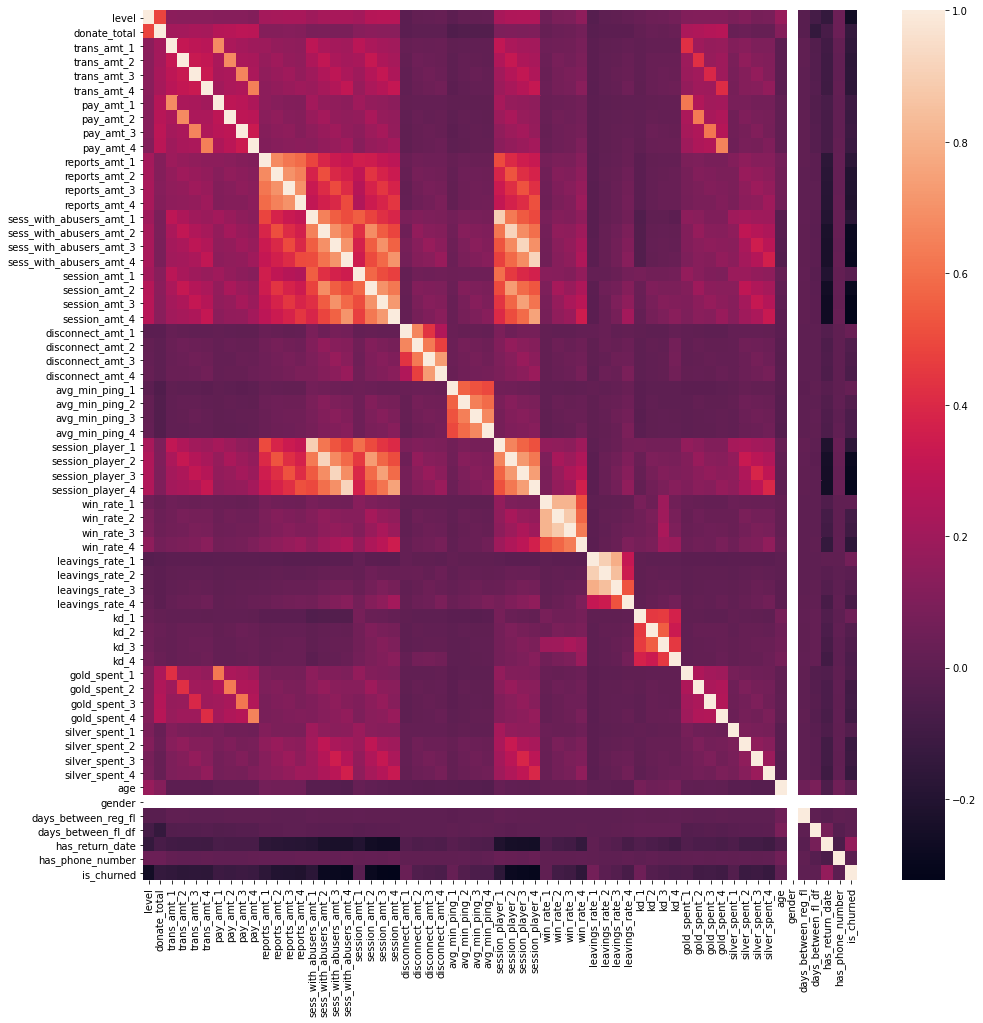

In [0]:
from seaborn import heatmap

fig, ax = plt.subplots(figsize=(16, 16))
heatmap(corr)
plt.show()

Визуализация показывает - чем светлее точка вне диагонали, тем сильнее линейная связь признаков, которые соответствуют координатам точки (т.е. ближе к 1 коэффициент корреляции Пирсона).

**На основании этого можно перебором исключать один из пары признаков, корреляция которых выше задаеаемого порога коэффициента корреляции**. Наличие высококоррелированных признаков критично для линейных моделей, поскольку может вызвать переобучение. Для методов, основанных на решающих деревьях, их наличие нежелательно в плане излишнего признакового пространства и использования памяти.

Перебор можно вести по одной из треугольных частей корреляционной матрицы по всем парам признаков (кроме целевого).

## Задание 3

***Как думаете, можно ли производить отбор признаков с помощью IV, а затем обучать модель случайного леса на отфильтрованном датасете? Ответ обоснуйте.***

Да, можно, поскольку метод весомости признака пришел из области работы с категориальными данными, а решающие деревья и методы, основанные на них, хорошо работают на данных такого рода. По сути метод кодирует некатегориальное признаковое пространство в категориальное (и по необходимости перекодирует категориальные признаки заново) в зависимости от целевого признака.